# Notebook Objectives
- Load data
- Re-order columns
- Add time encoding
- Separate weekday from weekend
- Explore sensor correlations
- Rescale/normalize
- Build sliding window representation 

In [63]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
import time
import os

In [64]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9.5, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

In [65]:
dataset_merged = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
                         filepath_or_buffer = './data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')
#dataset_weekdays = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
#                         filepath_or_buffer = './data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')
#dataset_weekends = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
#                         filepath_or_buffer = './data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')


In [30]:
#dataset_weekdays = np.load( './data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef.npy')

In [34]:
#dataset_weekdays[1:10]

In [66]:
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
#def split_and_rescale ( X ):
#    X_train, X_test = train_test_split( X, test_size = .25, shuffle = False )
#    scaler = StandardScaler()
#    scaler.fit(X_train)
#    X_train_scaled = scaler.transform( X_train )
#    X_test_scaled = scaler.transform( X_test )
#    return X_train_scaled, X_test_scaled

IndentationError: unexpected indent (<ipython-input-50-5025912f977f>, line 2)

In [39]:
#merged_train_scaled, merged_test_scaled = split_and_rescale(dataset_merged)
#S2_train_scaled, S2_test_scaled = split_and_rescale(dataset_weekends)
#S3_train_scaled, S3_test_scaled = split_and_rescale(dataset_weekdays)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# Re-order columns [ facilitates cross-correlation analysis ]

In [67]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1',
                    )        

In [68]:
orderedDataset  = dataset.reindex(index = dataset.index, columns = orderedSensorList)

In [43]:
#orderedDataset.plot(subplots=True);

In [58]:
orderedData_co2_1 = orderedDataset[['co2_1']]
#orderedData_S1_co2_2
#orderedData_S1_co2_3
#orderedData_S1_co2_4
#orderedData_S1_temp_1
#orderedData_S1_temp_2
#orderedData_S1_temp_3
#orderedData_S1_temp_4

In [59]:
orderedData_co2_1.head()

,co2_1
2018-01-01 00:00:03-08:00,480.750000
2018-01-01 00:15:03-08:00,480.750000
2018-01-01 00:30:03-08:00,477.817993
2018-01-01 00:45:03-08:00,486.612000
2018-01-01 01:00:03-08:00,486.612000


# Add time encoding/reference (day and hour)

In [69]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')

In [70]:
orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

# Separate Week from Weekend

In [71]:
saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)

In [72]:
weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]

In [73]:
weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]

In [74]:
weekdayData.shape, weekendData.shape

((25033, 22), (9901, 22))

# Explore Weekday and Weekend Sensor Cross-Correlations

In [75]:
xCorrWeekday = weekdayData.corr()
xCorrWeekend = weekendData.corr()

<IPython.core.display.Javascript object>


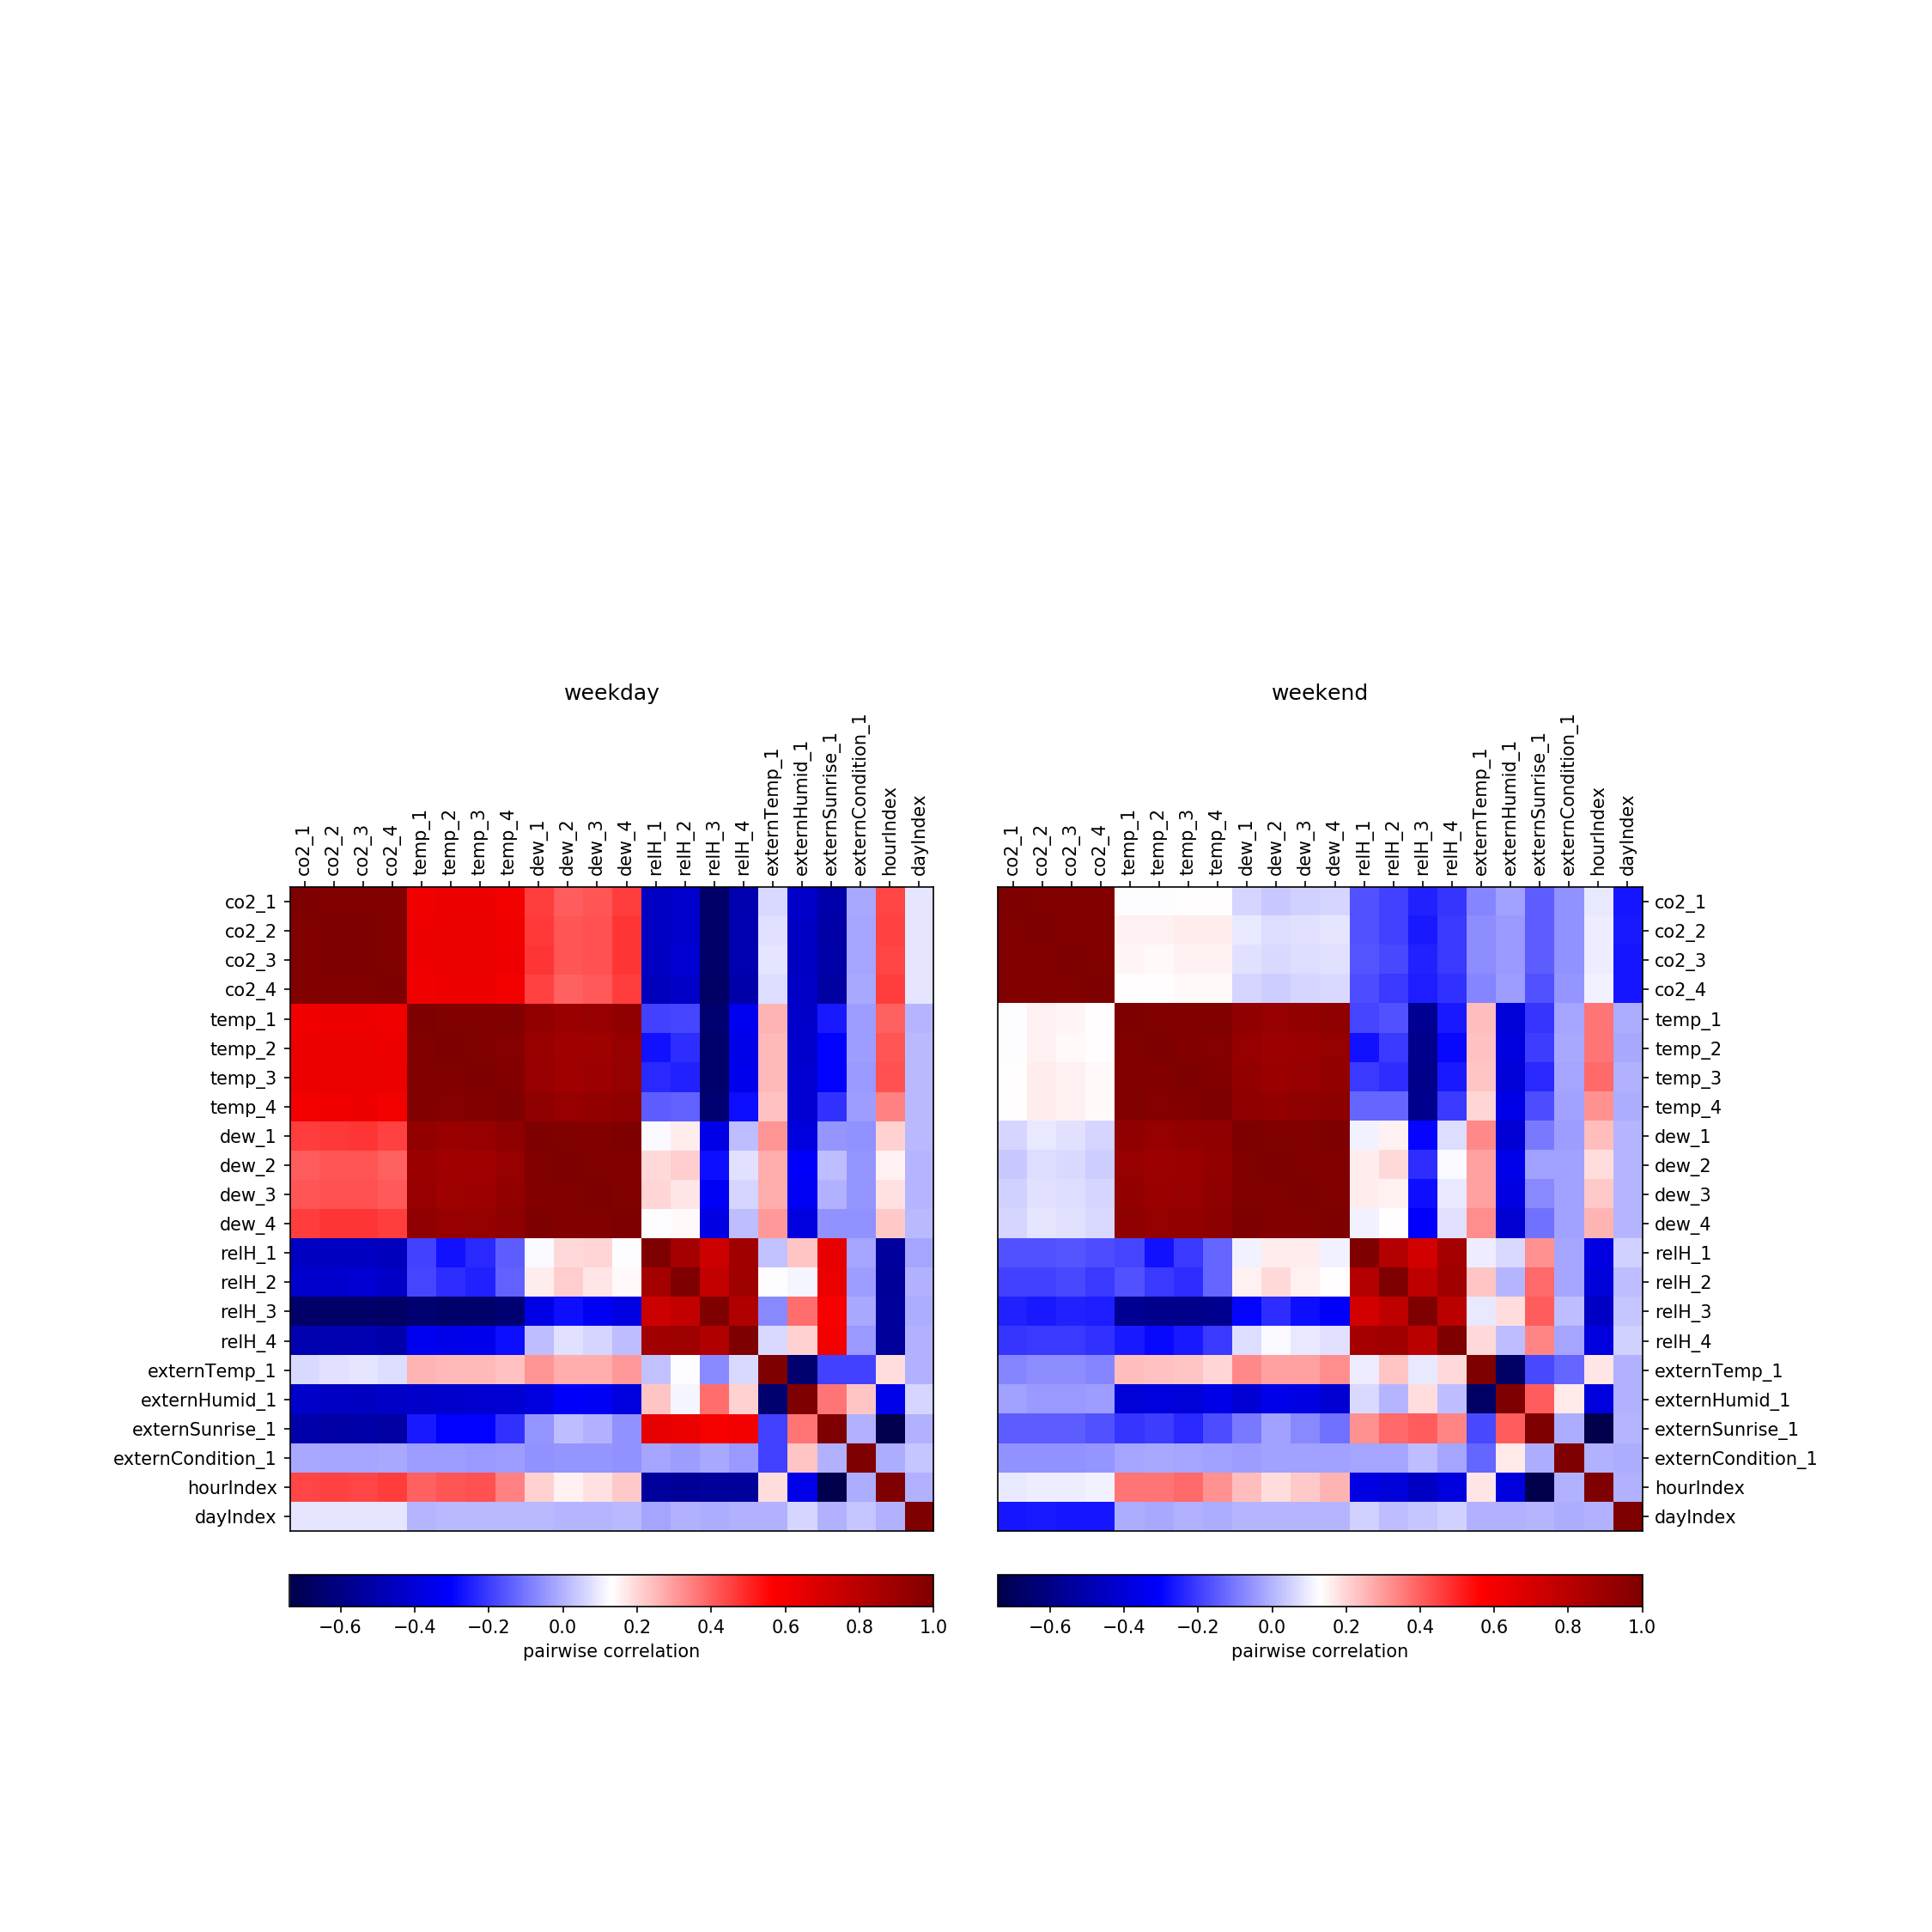

In [76]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, wspace=.1)

ax1 = plt.subplot(1,2,1)
im1 = plt.imshow(xCorrWeekday, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns)
plt.title('weekday')
ax1.xaxis.tick_top()

ax2 = plt.subplot(1,2,2)
im2 = plt.imshow(xCorrWeekend, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekend)), labels=weekendData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekend)), labels=weekendData.columns)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
plt.title('weekend')

fig.colorbar(im1, ax=ax1, label='pairwise correlation', orientation='horizontal', pad=.025)
fig.colorbar(im2, ax=ax2, label='pairwise correlation', orientation='horizontal', pad=.025)
plt.show()

# Rescale/Normalize [ focus on weekday data ]

In [77]:
continuousData = weekdayData.values[:, 0:17]
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit(continuousData)

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(categoricalData)

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame(index = weekdayData.index,
                                   data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                   columns = weekdayData.columns)

<IPython.core.display.Javascript object>


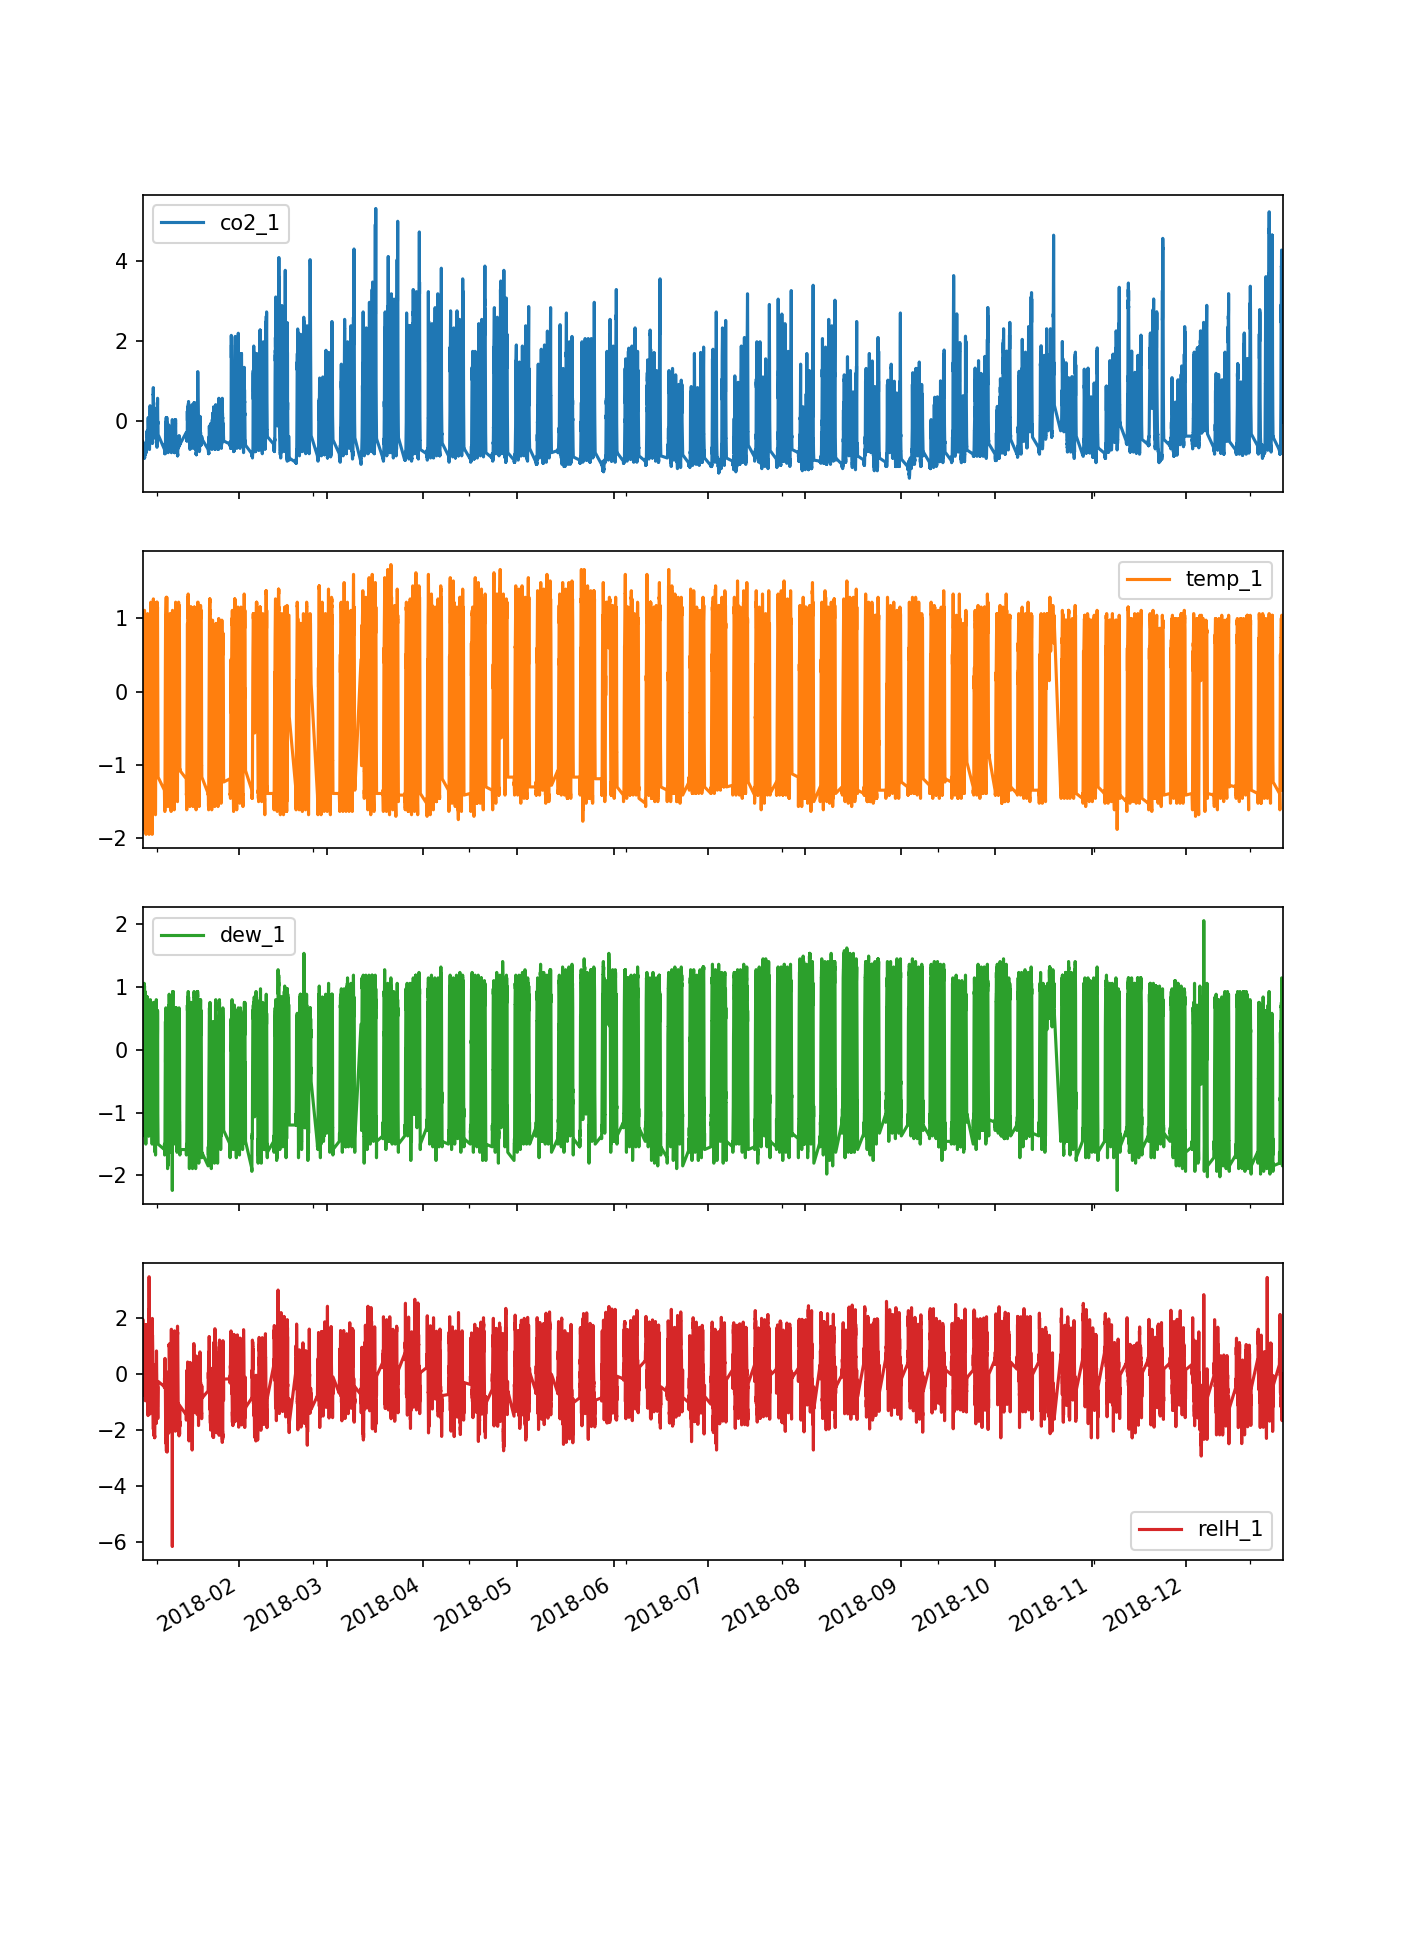

In [78]:
weekdayData_scaled[['co2_1', 'temp_1', 'dew_1', 'relH_1']].plot(subplots=True);

# Convert to Sliding Window Representation


In [79]:
def build_train_data ( inputDataframe, outputFilename, advanceTimedeltaStr = '15 min' ):

    npFilename = outputFilename + '.npy'
    npFilenameSamplebounds = outputFilename + '_sampleBounds' + '.npy'
    rebuildFlag = True # flips if file exists in cache and user agrees to restore

    windowCounter = correctLenWindows = fixedWindows = 1
    trimNeededWindows = extensionNeededWindows = 1
    sumExtensionAmount = sumTrimAmount = 0
    
    def extract_one_day( startTime, endTime, idealIndex, nExtensionAttempts=10 ):        
        nonlocal correctLenWindows, trimNeededWindows, extensionNeededWindows, \
                sumExtensionAmount, sumTrimAmount, fixedWindows

        oneDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                         & (inputDataframe.index < endTime)]
        
        if len(oneDay) == len(idealIndex):
            correctLenWindows += 1

        # available data in day range is too long -- trimming required
        if len(oneDay) > len(idealIndex):
            trimNeededWindows += 1
            sumTrimAmount += len(oneDay) - len(idealIndex)
            oneDay = oneDay.iloc[0:len(idealIndex)]
        
        # available data in day range is of insufficient length -- extension required 
        if len(oneDay) < len(idealIndex):
            extensionNeededWindows += 1
            sumExtensionAmount += len(idealIndex) - len(oneDay)
            
            oneDay = None
            # attempt to extend one sample at a time up to nExtensionAttempts
            for iExtensionAttempt in range( nExtensionAttempts ):
                endTime += pd.Timedelta( advanceTimedeltaStr)
                extendedDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                                 & (inputDataframe.index < endTime)]
                # sucessfully extened data slice
                if len( extendedDay) == len( idealIndex ):
                    fixedWindows += 1
                    oneDay = extendedDay
                    break
        
        # only happens when available data requires extension beyond nExtensionAttempts
        if oneDay is None:
            return None, None, None
        
        assert ( len(oneDay) == len(idealIndex) )
        return oneDay.values.reshape(1,-1, order = 'F'), oneDay.index[0], oneDay.index[-1]
    
    
    # check cache
    if Path(npFilename).is_file() and Path(npFilenameSamplebounds).is_file():
        print('created on: {} \n\t size: {} MB'.format( time.ctime(os.path.getctime(npFilename)), 
                                                        Path(npFilename).stat().st_size / 1e6 ))
        if 'y' == input('load from cache? (y/n): '):
            npTrainMatrix = np.load(npFilename, allow_pickle=True) # load from cache
            sampleIndexBounds = np.load(npFilenameSamplebounds, allow_pickle=True)
            rebuildFlag = False
    
    if rebuildFlag:
        npTrainMatrix = None
        sampleIndexBounds = None
        npTestMatrix = None

        startTime = inputDataframe.index[0]
        while(1):
            endTime = startTime + pd.Timedelta('1 day');
            
            # terminate window extraction once end of dataset is reached
            if startTime > inputDataframe.index[-1] or endTime > inputDataframe.index[-1]:
                break
            
            # generate an ideal index [ 96 x 15 min samples from current startTime ]
            idealIndex = pd.date_range(start=startTime, end=endTime, freq='15T', closed='left' );
            
            # ensure that current window is a weekday
            if (idealIndex.dayofweek < 5).all():
                
                # gather data from sensor streams going one day forward
                dataWindow, windowStartIndex, windowEndIndex = \
                    extract_one_day ( startTime, endTime, idealIndex)
                
                # dataWindow is none only when more than ~10 samples are missing                
                if dataWindow is not None:                
                    windowCounter += 1
                    
                    # first iteration is a direct assignment, all others require appending 
                    if npTrainMatrix is None:
                        npTrainMatrix = dataWindow;
                        sampleIndexBounds = np.array([windowStartIndex, windowEndIndex]);
                    else:
                        assert( dataWindow.shape[1] == npTrainMatrix.shape[1] ) # import ipdb; ipdb.set_trace()
                        npTrainMatrix = np.append( npTrainMatrix, dataWindow, axis = 0 );
                        sampleIndexBounds = np.append( sampleIndexBounds, 
                                                       np.array([windowStartIndex, windowEndIndex]) , axis = 0);
                        
            else:
                pass # skipping -- day segment includes a piece of the weekend
            
            avgTrim = np.round(sumTrimAmount/trimNeededWindows, decimals=2);
            avgExtend = np.round(sumExtensionAmount/extensionNeededWindows, decimals=2);
            
            # advance to next sample
            startTime = startTime + pd.Timedelta(advanceTimedeltaStr);

        print('nWindows {} - nCorrect {}; nTrimNeeded {} | avg.trim {}; nExtendNeeded {} | avg.ext {} | fixedViaExtension {}'.format(windowCounter, correctLenWindows, 
                       trimNeededWindows, avgTrim, extensionNeededWindows, avgExtend, fixedWindows), end='\r')

        print('\nwriting to cache')
        
        # save to cache
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        np.save(npFilename, npTrainMatrix)
        np.save(npFilenameSamplebounds, sampleIndexBounds)

    if sampleIndexBounds.shape[0] != npTrainMatrix.shape[0]:
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        
    return npTrainMatrix, sampleIndexBounds

In [82]:
%%time
outputFilename = './data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef'
npTrainMatrix, sampleIndexBounds = build_train_data ( weekdayData_scaled, outputFilename )
'''
nWindows 20008 - nCorrect 17928; nTrimNeeded 439 | avg.trim 3.99; nExtendNeeded 1656 | avg.ext 1.56 | fixedViaExtension 1643
writing to cache
CPU times: user 16min 19s, sys: 19min 33s, total: 35min 52s
Wall time: 35min 53s
'''

created on: Fri Jul 12 17:15:08 2019 
	 size: 338.0384 MB
load from cache? (y/n): y
CPU times: user 366 ms, sys: 194 ms, total: 559 ms
Wall time: 5.66 s


In [83]:
npTrainMatrix.shape

(20007, 2112)

In [337]:
npTrainMatrix[1,0:96]

array([-0.54419175, -0.57077136, -0.4910508 , -0.4910508 , -0.59734183,
       -0.57077136, -0.57077136, -0.54419175, -0.59734183, -0.59734183,
       -0.54419175, -0.54419175, -0.59734183, -0.57077136, -0.54419175,
       -0.67706239, -0.67706239, -0.70364171, -0.70364171, -0.70364171,
       -0.70364171, -0.70364171, -0.70364171, -0.70364171, -0.73021219,
       -0.70364171, -0.75679179, -0.70364171, -0.70364171, -0.75679179,
       -0.70364171, -0.73021219, -0.78336227, -0.80993274, -0.75679179,
       -0.75679179, -0.75679179, -0.75679179, -0.78336227, -0.78336227,
       -0.78336227, -0.80993274, -0.80993274, -0.80993274, -0.80993274,
       -0.78336227, -0.78336227, -0.78336227, -0.80993274, -0.73021219,
       -0.80993274, -0.80993274, -0.80993274, -0.83651235, -0.83651235,
       -0.86308282, -0.9162329 , -0.88966242, -0.88966242, -0.88966242,
       -0.9162329 , -0.88966242, -0.88966242, -0.86308282, -0.9162329 ,
       -0.86308282, -0.83651235, -0.80993274, -0.80993274, -0.80

In [341]:
weekdayData_scaled[1:96]

,co2_1,co2_2,co2_3,co2_4,temp_1,temp_2,temp_3,temp_4,dew_1,dew_2,...,relH_1,relH_2,relH_3,relH_4,externTemp_1,externHumid_1,externSunrise_1,externCondition_1,hourIndex,dayIndex
2018-01-01 00:15:03-08:00,-0.544192,-0.601379,-0.566085,-0.627250,-1.748649,-1.595376,-1.488387,-1.394638,-1.153817,-1.182499,...,0.504717,0.814047,1.101336,1.510195,-1.517908,0.657143,1.0,0.500,0.000000,0.0
2018-01-01 00:30:03-08:00,-0.570771,-0.575309,-0.566085,-0.627250,-1.770985,-1.619114,-1.535011,-1.455517,-1.197150,-1.229398,...,0.461277,0.885682,1.058501,1.578237,-1.517908,0.671429,1.0,0.500,0.000000,0.0
2018-01-01 00:45:03-08:00,-0.491051,-0.575309,-0.566085,-0.601043,-1.815657,-1.690329,-1.604947,-1.496103,-1.240507,-1.276270,...,0.620719,0.837291,1.174799,1.467355,-1.517908,0.671429,1.0,0.500,0.000000,0.0
2018-01-01 01:00:03-08:00,-0.491051,-0.601379,-0.539805,-0.601043,-1.837993,-1.737806,-1.651571,-1.516396,-1.283864,-1.276270,...,0.533218,0.848901,1.228265,1.412039,-1.517908,0.671429,1.0,0.500,0.041667,0.0
2018-01-01 01:15:03-08:00,-0.597342,-0.575309,-0.566085,-0.522414,-1.882666,-1.809021,-1.674883,-1.516396,-1.370579,-1.463866,...,0.596105,0.752287,0.845377,1.179638,-1.517908,0.671429,1.0,0.500,0.041667,0.0
2018-01-01 01:30:03-08:00,-0.570771,-0.549230,-0.539805,-0.469992,-1.837993,-1.809021,-1.674883,-1.516396,-1.327222,-1.229398,...,1.055523,0.921018,1.271606,1.412039,-1.603460,0.671429,1.0,0.500,0.041667,0.0
2018-01-01 01:45:03-08:00,-0.570771,-0.523160,-0.460957,-0.601043,-1.815657,-1.809021,-1.651571,-1.455517,-1.283864,-1.370068,...,1.246338,0.969680,0.878014,1.797093,-1.603460,0.671429,1.0,0.500,0.041667,0.0
2018-01-01 02:00:03-08:00,-0.544192,-0.497090,-0.513517,-0.601043,-1.770985,-1.809021,-1.651571,-1.414931,-1.197150,-1.182499,...,1.598389,1.189646,1.101336,2.035647,-1.603460,0.671429,1.0,0.500,0.083333,0.0
2018-01-01 02:15:03-08:00,-0.597342,-0.549230,-0.513517,-0.522414,-1.748649,-1.809021,-1.651571,-1.394638,-1.153817,-1.135600,...,1.690557,1.300572,1.197411,1.952698,-1.603460,0.671429,1.0,0.500,0.083333,0.0
2018-01-01 02:30:03-08:00,-0.597342,-0.549230,-0.539805,-0.601043,-1.748649,-1.737806,-1.604947,-1.354052,-1.110460,-1.088701,...,1.945476,1.288206,1.187251,2.009131,-1.603460,0.671429,1.0,0.500,0.083333,0.0


In [272]:
weekendData_scaled.shape

NameError: name 'weekendData_scaled' is not defined

In [111]:
npTrainMatrix[96,:].shape

(2112,)

# Plot Sliding Windows

In [87]:
samplesInADay = 96 # 96 samples 15 minutes aparts = 24 hours 

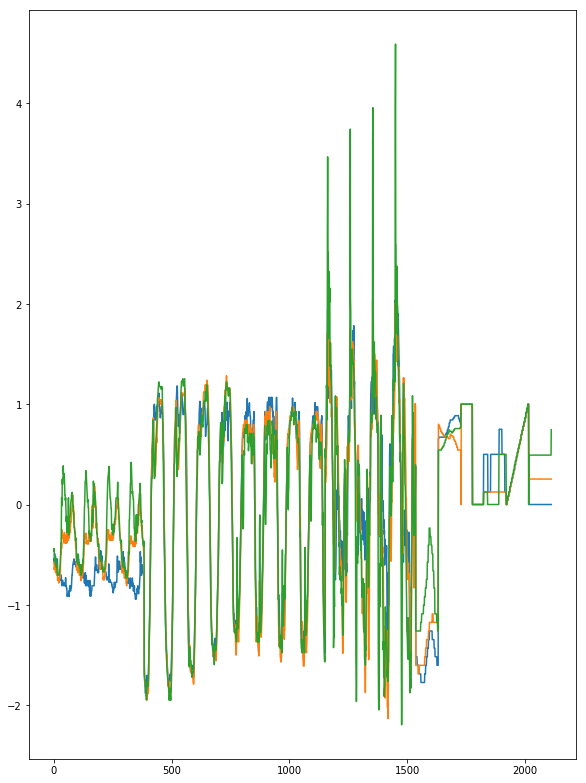

In [279]:
nSlidingWindowsToPlot = 3
plt.figure()
for iDay in range(nSlidingWindowsToPlot):
    startIndex = (iDay) * samplesInADay
    plt.plot(npTrainMatrix[startIndex,:])

In [127]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

In [297]:
npTrainMatrix[0,:].shape

(2112,)

In [291]:
npTrainMatrix[0,0:25]

array([-0.54419175, -0.54419175, -0.57077136, -0.4910508 , -0.4910508 ,
       -0.59734183, -0.57077136, -0.57077136, -0.54419175, -0.59734183,
       -0.59734183, -0.54419175, -0.54419175, -0.59734183, -0.57077136,
       -0.54419175, -0.67706239, -0.67706239, -0.70364171, -0.70364171,
       -0.70364171, -0.70364171, -0.70364171, -0.70364171, -0.70364171])

In [121]:
dataLoaderTrain = DataLoader( npTrainMatrix.astype('float32'), 
                                 batch_size = 16, 
                                 shuffle = True )

dataLoaderTest = DataLoader( npTrainMatrix.astype('float32'), 
                                 batch_size = 1, 
                                 shuffle = False )

In [145]:
inputDimensionality = npTrainMatrix.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

In [146]:
!pip install git+https://github.com/TimeSynth/TimeSynth.git

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-1qva076l
  Running setup.py bdist_wheel for timesynth ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-me3fju4b/wheels/00/d5/b7/7f6f768fc3457c8292ae5a0856c51089efa4409ec2811fbcdd
Successfully built timesynth
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [135]:
from nnViz_pytorch import *

In [136]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

579
5798496


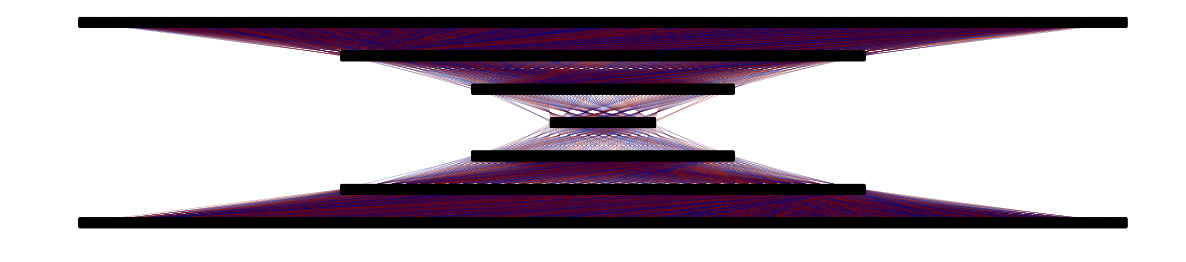

elapsed time: 67.5441517829895


In [147]:
startTime = time.time()

plt.figure(figsize=(20,4)); ax = plt.gca()

visualize_model(model, ax)

plt.axis('tight'); plt.axis('off'); plt.show()

print('elapsed time: {}'.format(time.time()-startTime))

In [148]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

In [139]:
def train_model ( model, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

In [149]:
startTime = time.time()

model, lossHistory = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 5 )

print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 5 -- avg batch loss: 140.55697736889124
epoch 1 of 5 -- avg batch loss: 89.41361992433667
epoch 2 of 5 -- avg batch loss: 81.07852761819959
epoch 3 of 5 -- avg batch loss: 77.51452345773578
epoch 4 of 5 -- avg batch loss: 74.41842972114682
elapsed time : 40.70852828025818 


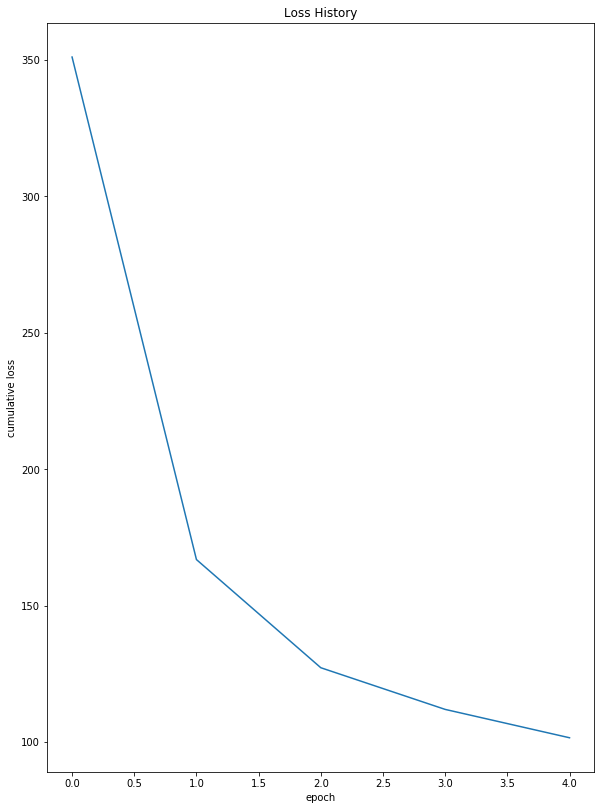

In [141]:
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

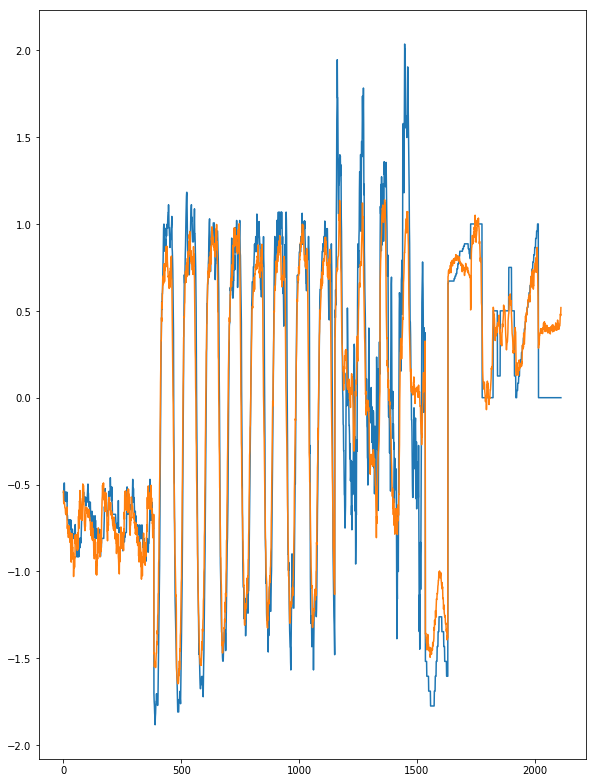

In [142]:
sample = iter(dataLoaderTest).next()[0] # get first element from sample batch        
reconstruction = model.forward(sample.to(targetDevice))
plt.plot(sample.numpy())
plt.plot(reconstruction.data.cpu().numpy())

In [213]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 1000):
    cumulative_errors = 0
    for iSample in range(nEvals):
        
        sample = iter(dataLoader).next()[0] # get first element from sample batch 
        reconstruction = model.forward(sample.to(targetDevice))
        
        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
        cumulative_errors += error
        if iSample == 999:
            plt.figure(figsize=(9,5))
            ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
            ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    
            
            ax1.plot(sampleNumpy)
            ax1.plot(reconstructionNumpy, '-.')
            ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
            ax1.legend(['input data', 'reconstruction'])

            ax2.plot(error)
            ax2.legend( ['reconstruction error'] )

    return cumulative_errors
            
            


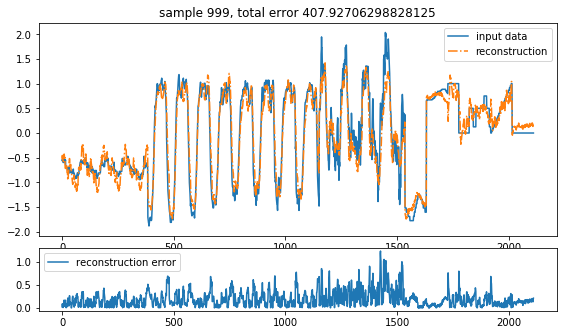

In [214]:
cumulative_errors = evaluate_model( model, dataLoaderTest, targetDeviceGPU)

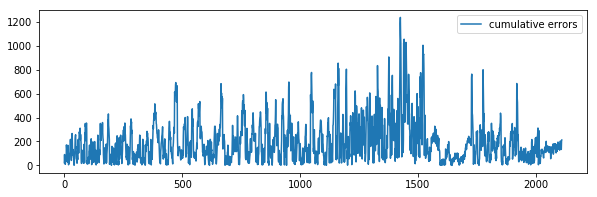

In [215]:
# Simulate test 1000 times 
plt.figure()
ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=3)
ax3.plot(cumulative_errors)
ax3.legend( ['cumulative errors'] )

In [226]:
#Get the mean and variance of the simulation
mn = cumulative_errors.mean()
std = np.sqrt(cumulative_errors.var())
print(mn)
print(std)


193.1473
173.10399


203.7964

In [372]:
anomallies = []
for ind in range(len(cumulative_errors)): 
    if cumulative_errors[ind] < (mn-3*std) or cumulative_errors[ind] > (mn+3*std):
        target = ind % 22
        anomallies.append(target)
        
anomallies
#len(cumulative_errors)

[14,
 15,
 18,
 20,
 9,
 9,
 12,
 13,
 14,
 6,
 16,
 17,
 18,
 19,
 20,
 10,
 11,
 12,
 13,
 17,
 18,
 19,
 20,
 21,
 0,
 1,
 9,
 14,
 16,
 3,
 4,
 5,
 6,
 7,
 8,
 12,
 13,
 17]

In [373]:
DetectionList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1',
                     'dayIndex', 
                     'hourIndex'
                    )        

In [374]:
ErrorDic ={}
for each in anomallies:
    if DetectionList[each] not in ErrorDic:
        ErrorDic[DetectionList[each]] = 1
    else:
        ErrorDic[DetectionList[each]] += 1
ErrorDic


{'relH_3': 3,
 'relH_4': 1,
 'externSunrise_1': 3,
 'dayIndex': 3,
 'dew_2': 3,
 'relH_1': 3,
 'relH_2': 3,
 'temp_3': 2,
 'externTemp_1': 2,
 'externHumid_1': 3,
 'externCondition_1': 2,
 'dew_3': 1,
 'dew_4': 1,
 'hourIndex': 1,
 'co2_1': 1,
 'co2_2': 1,
 'co2_4': 1,
 'temp_1': 1,
 'temp_2': 1,
 'temp_4': 1,
 'dew_1': 1}